In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import os

from generator import *
from discriminator import *
from utils import * 
from loss import *
from dataset import load_sketchygan_dataset

In [2]:
#PARAMS

# Learning rates for discriminator and generator based on the SketchyGAN paper
d_lr = 0.0002
g_lr = 0.0001

num_epochs = 5
batch_size = 8

In [3]:
photo_sketch_dl = load_sketchygan_dataset(batch_size)[1]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

netG = Generator(num_classes=125).cuda()

netD = Discriminator(num_classes=125, init_in_channels=3).cuda()


In [5]:
dis_criterion = nn.BCEWithLogitsLoss()
aux_criterion = nn.CrossEntropyLoss()

In [6]:
optimizerD = optim.Adam(netD.parameters(), lr=d_lr)
optimizerG = optim.Adam(netG.parameters(), lr=g_lr)

In [7]:
G_losses = []
D_losses = []
img_list = []
iters = 0
acc_list = []

In [8]:
real_label = 1.0
fake_label = 0.0

In [27]:
npzfile = np.load("dataset_stats.npz")
photos_mean = npzfile['photos_mean']
photos_scaling = npzfile['photos_scaling']
photos_scaling = float(photos_scaling)

In [ ]:
print("Begin training ...")
begin_time = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(photo_sketch_dl):
        # Assuming data is a list of [photos, labels, sketches]
        input_photos, input_sketches, input_labels = data
        input_photos = input_photos.cuda()
        input_sketches = input_sketches.cuda()
        input_labels = input_labels.cuda()
        
        ## Update netD: maximize log(D(y)) + log(1-D(G(x,z)))
        # Train with all-real images
        netD.zero_grad()
        # Format batch
        dis_label = torch.full((batch_size, 1), real_label, device=device)
        aux_label = input_labels #torch.full((batch_size,), input_labels, device=device, dtype=torch.long)
        # Forward pass real batch thru D
        dis_output_real, aux_output_real = netD(input_photos)
        
        # Calculate loss on all-real batch
        dis_errD_real = dis_criterion(dis_output_real, dis_label) #pred_real_natural
        aux_errD_real = aux_criterion(aux_output_real, aux_label) #pred_real_class
        # Calculate gradients for D in the backward pass
        errD_real = dis_errD_real + aux_errD_real
        errD_real.backward(retain_graph=True)
        D_x = dis_output_real.mean().item()

        # compute the current classification accuracy
        accuracy = compute_acc(aux_output_real, aux_label)
        acc_list.append(accuracy)

        ## Train with all-fake batch
        # Generate fake image batch with G 
        # Generator outputs generated image and noise vector applied on the bottleneck
        fake, z = netG(input_labels, input_sketches)
        dis_label.data.fill_(fake_label)
        # Classify all fake batch with D
        dis_output_fake, aux_output_fake = netD(fake)
        # Calculate D's loss on the all-fake batch
        dis_errD_fake = dis_criterion(dis_output_fake, dis_label) #pred_fake_natural
        aux_errD_fake = aux_criterion(aux_output_fake, aux_label) #pred_fake_class
        # Calculate the gradients for this batch
        errD_fake = dis_errD_fake + aux_errD_fake
        errD_fake.backward(retain_graph=True)
        D_G_z1 = dis_output_fake.mean().item()
        # Calculate DRAGAN Loss
        grad_penalty = gradient_penalty(netD, input_photos, fake)
        grad_penalty.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake + grad_penalty
        # Update D
        optimizerD.step()

        ## Update G Network: maximize log(D(G(x,z)))
        netG.zero_grad()
        dis_label.data.fill_(real_label) #fake labels are real label for generator
        # Since we just updated D, perform another forward pass of all-fake batch thru D
        dis_output, aux_output = netD(fake)
        # Calculate G's loss based on this output
        dis_errG = dis_criterion(dis_output, dis_label)
        aux_errG = aux_criterion(aux_output, aux_label)
        # Calculate gradients for G
        errG = dis_errG - aux_errG
        errG.backward(retain_graph=True)
        # Supervised loss
        supervised_loss_G = supervised_loss(fake, input_photos)
        # Perceptual loss
        perceptual_loss_G = perceptual_loss(fake, input_photos)
        # Diversity Loss; Create another fake image
        fake_alt , z_alt = netG(input_labels, input_sketches)
        diversity_loss_G = diversity_loss(fake, fake_alt, z, z_alt)
        errG_spd = supervised_loss_G + perceptual_loss_G[0] + diversity_loss_G
        errG_spd.backward()
        D_G_z2 = dis_output.mean().item()        
        # Update G
        optimizerG.step()
        
        # Print training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(photo_sketch_dl),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)
                )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        run_name = 'second_run'
        # Save real and fake images periodically
        if i % 15 == 0:
            print('Saving images!')
            
            images_dir = os.path.join('../learning/images/', run_name)
            real_image_path = os.path.join(images_dir, 'real_sample_e%d_b%d.png' % (epoch, i))
            real_image = input_photos[0]
            real_image = real_image * photos_scaling
            for j in range(3):
                real_image[j] += photos_mean[j]
            torchvision.utils.save_image(real_image, real_image_path)

            fake_image_path = os.path.join(images_dir, 'fake_sample_e%d_b%d.png' % (epoch, i))
            fake_image = fake[0]
            fake_image = fake_image * photos_scaling
            for j in range(3):
                fake_image[j] += photos_mean[j]
            torchvision.utils.save_image(fake_image, fake_image_path)
            
        # Save model periodically
        if i % 250 == 0:
            print('Saving model!')
            count = len(photo_sketch_dl) * epoch + i
            model_dir = '../learning/models/'
            model_path = os.path.join(model_dir, '{}_c{}'.format(run_name, count))
            torch.save({
                'discriminator': netD.state_dict(),
                'generator': netG.state_dict(),
                'count': count,
                }, model_path)


Begin training ...


/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/chihchungwang/Documents/git/Sketch2img/final/loss.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x).data.cpu().numpy()


[0/5][0/9321]	Loss_D: 11.5476	Loss_G: 4.3382	D(x): 5.8552	D(G(z)): -5.7238 / -8.7077
Saving images!
Saving model!
Saving images!
Saving images!
Saving images!
[0/5][50/9321]	Loss_D: 14.6830	Loss_G: 6.2283	D(x): -2.5069	D(G(z)): -9.7625 / -10.8094
Saving images!
Saving images!
Saving images!
[0/5][100/9321]	Loss_D: 12.3115	Loss_G: 2.1274	D(x): 5.1629	D(G(z)): -4.7660 / -6.6147
Saving images!
Saving images!
Saving images!
[0/5][150/9321]	Loss_D: 13.1535	Loss_G: 0.4769	D(x): 5.1490	D(G(z)): -4.6757 / -5.1541
Saving images!
Saving images!
Saving images!
Saving images!
[0/5][200/9321]	Loss_D: 12.6193	Loss_G: 4.7071	D(x): 2.4255	D(G(z)): -7.6764 / -9.4979
Saving images!
Saving images!
Saving images!
[0/5][250/9321]	Loss_D: 11.4600	Loss_G: 6.0417	D(x): 8.7675	D(G(z)): -7.6906 / -10.2141
Saving model!
Saving images!
Saving images!
Saving images!
[0/5][300/9321]	Loss_D: 11.2806	Loss_G: 3.0455	D(x): 7.1101	D(G(z)): -6.4003 / -7.6597
Saving images!
Saving images!
Saving images!
Saving images!
[0/

In [ ]:
print("Begin training ...")
state_dict = torch.load('../learning/models/second_run_c9250')
netG.load_state_dict(state_dict['generator'])
netD.load_state_dict(state_dict['discriminator'])

epoch = 1
for i, data in enumerate(photo_sketch_dl):
    # Assuming data is a list of [photos, labels, sketches]
    input_photos, input_sketches, input_labels = data
    input_photos = input_photos.cuda()
    input_sketches = input_sketches.cuda()
    input_labels = input_labels.cuda()

    ## Update netD: maximize log(D(y)) + log(1-D(G(x,z)))
    # Train with all-real images
    netD.zero_grad()
    # Format batch
    dis_label = torch.full((batch_size, 1), real_label, device=device)
    aux_label = input_labels #torch.full((batch_size,), input_labels, device=device, dtype=torch.long)
    # Forward pass real batch thru D
    dis_output_real, aux_output_real = netD(input_photos)

    # Calculate loss on all-real batch
    dis_errD_real = dis_criterion(dis_output_real, dis_label) #pred_real_natural
    aux_errD_real = aux_criterion(aux_output_real, aux_label) #pred_real_class
    # Calculate gradients for D in the backward pass
    errD_real = dis_errD_real + aux_errD_real
    errD_real.backward(retain_graph=True)
    D_x = dis_output_real.mean().item()

    # compute the current classification accuracy
    accuracy = compute_acc(aux_output_real, aux_label)
    acc_list.append(accuracy)

    ## Train with all-fake batch
    # Generate fake image batch with G 
    # Generator outputs generated image and noise vector applied on the bottleneck
    fake, z = netG(input_labels, input_sketches)
    dis_label.data.fill_(fake_label)
    # Classify all fake batch with D
    dis_output_fake, aux_output_fake = netD(fake)
    # Calculate D's loss on the all-fake batch
    dis_errD_fake = dis_criterion(dis_output_fake, dis_label) #pred_fake_natural
    aux_errD_fake = aux_criterion(aux_output_fake, aux_label) #pred_fake_class
    # Calculate the gradients for this batch
    errD_fake = dis_errD_fake + aux_errD_fake
    errD_fake.backward(retain_graph=True)
    D_G_z1 = dis_output_fake.mean().item()
    # Calculate DRAGAN Loss
    grad_penalty = gradient_penalty(netD, input_photos, fake)
    grad_penalty.backward()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake + grad_penalty
    # Update D
    optimizerD.step()

    ## Update G Network: maximize log(D(G(x,z)))
    netG.zero_grad()
    dis_label.data.fill_(real_label) #fake labels are real label for generator
    # Since we just updated D, perform another forward pass of all-fake batch thru D
    dis_output, aux_output = netD(fake)
    # Calculate G's loss based on this output
    dis_errG = dis_criterion(dis_output, dis_label)
    aux_errG = aux_criterion(aux_output, aux_label)
    # Calculate gradients for G
    errG = dis_errG - aux_errG
    errG.backward(retain_graph=True)
    # Supervised loss
    supervised_loss_G = supervised_loss(fake, input_photos)
    # Perceptual loss
    perceptual_loss_G = perceptual_loss(fake, input_photos)
    # Diversity Loss; Create another fake image
    fake_alt , z_alt = netG(input_labels, input_sketches)
    diversity_loss_G = diversity_loss(fake, fake_alt, z, z_alt)
    errG_spd = supervised_loss_G + perceptual_loss_G[0] + diversity_loss_G
    errG_spd.backward()
    D_G_z2 = dis_output.mean().item()        
    # Update G
    optimizerG.step()

    # Print training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(photo_sketch_dl),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)
            )

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    run_name = 'second_run'
    # Save real and fake images periodically
    if i % 15 == 0:
        print('Saving images!')

        images_dir = os.path.join('../learning/images/', run_name)
        real_image_path = os.path.join(images_dir, 'real_sample_e%d_b%d.png' % (epoch, i))
        real_image = input_photos[0]
        real_image = real_image * photos_scaling
        for j in range(3):
            real_image[j] += photos_mean[j]
        torchvision.utils.save_image(real_image, real_image_path)

        fake_image_path = os.path.join(images_dir, 'fake_sample_e%d_b%d.png' % (epoch, i))
        fake_image = fake[0]
        fake_image = fake_image * photos_scaling
        for j in range(3):
            fake_image[j] += photos_mean[j]
        torchvision.utils.save_image(fake_image, fake_image_path)

    # Save model periodically
    if i % 500 == 0:
        print('Saving model!')
        count = len(photo_sketch_dl) * epoch + i
        model_dir = '../learning/models/'
        model_path = os.path.join(model_dir, '{}_c{}'.format(run_name, count))
        torch.save({
            'discriminator': netD.state_dict(),
            'generator': netG.state_dict(),
            }, model_path)


Begin training ...


/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/chihchungwang/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/chihchungwang/Documents/git/Sketch2img/final/loss.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x).data.cpu().numpy()


[1/5][0/9321]	Loss_D: 8.2705	Loss_G: 0.3042	D(x): 5.3964	D(G(z)): -4.8176 / -4.7719
Saving images!
Saving model!
Saving images!
Saving images!
Saving images!
[1/5][50/9321]	Loss_D: 9.7814	Loss_G: -3.0566	D(x): 12.2336	D(G(z)): 0.4861 / -0.6072
Saving images!
Saving images!
Saving images!
[1/5][100/9321]	Loss_D: 8.2006	Loss_G: 2.3913	D(x): 10.5919	D(G(z)): -5.1607 / -6.4687
Saving images!
Saving images!
Saving images!
[1/5][150/9321]	Loss_D: 8.9819	Loss_G: -0.7562	D(x): 8.5681	D(G(z)): -2.1672 / -3.5951
Saving images!
Saving images!
Saving images!
Saving images!
[1/5][200/9321]	Loss_D: 8.2822	Loss_G: 2.2340	D(x): 5.6074	D(G(z)): -5.2411 / -6.5551
Saving images!
Saving images!
Saving images!
[1/5][250/9321]	Loss_D: 9.6367	Loss_G: 0.1967	D(x): 1.5943	D(G(z)): -3.9691 / -4.9549
Saving images!
Saving images!
Saving images!
[1/5][300/9321]	Loss_D: 7.8398	Loss_G: 5.1605	D(x): 5.1138	D(G(z)): -7.5828 / -9.6143
Saving images!
Saving images!
Saving images!
Saving images!
[1/5][350/9321]	Loss_D: 

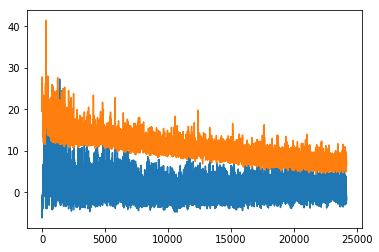

In [37]:
plt.plot(G_losses)
plt.plot(D_losses)